In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gudhi
from pogo import Pogo
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from umap import UMAP,plot


/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pogo=Pogo()


In [3]:
hf = h5py.File('Quake_Smart-seq2_Diaphragm/data.h5', 'r')

In [4]:
hf

<HDF5 file "data.h5" (mode r)>

In [5]:
hf.keys()

<KeysViewHDF5 ['exprs', 'obs', 'obs_names', 'uns', 'var', 'var_names']>

In [6]:
exprs = hf.get('exprs')
np.array(exprs)

array(['data', 'indices', 'indptr', 'shape'], dtype='<U7')

In [7]:
obs = hf.get('obs')
np.array(obs)

array(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'channel',
       'cluster', 'dataset_name', 'donor', 'free_annotation', 'gender',
       'organ', 'organism', 'platform', 'region'], dtype='<U19')

In [136]:
ground_truth = np.array(obs.get('cluster'))
ground_truth.shape

(870,)

In [9]:
obs_names = hf.get('obs_names')
np.array(obs_names)

array([b'A8.D042105.3_11_M.1.1', b'K10.D042105.3_11_M.1.1',
       b'L13.D042105.3_11_M.1.1', b'M15.D042105.3_11_M.1.1',
       b'N17.D042105.3_11_M.1.1', b'O19.D042105.3_11_M.1.1',
       b'P22.D042105.3_11_M.1.1', b'A9.D042105.3_11_M.1.1',
       b'B12.D042105.3_11_M.1.1', b'C14.D042105.3_11_M.1.1',
       b'B11.D042105.3_11_M.1.1', b'D16.D042105.3_11_M.1.1',
       b'E19.D042105.3_11_M.1.1', b'C13.D042105.3_11_M.1.1',
       b'D15.D042105.3_11_M.1.1', b'E18.D042105.3_11_M.1.1',
       b'F21.D042105.3_11_M.1.1', b'H2.D042105.3_11_M.1.1',
       b'I4.D042105.3_11_M.1.1', b'J8.D042105.3_11_M.1.1',
       b'F22.D042105.3_11_M.1.1', b'A10.D042105.3_11_M.1.1',
       b'C15.D042105.3_11_M.1.1', b'D17.D042105.3_11_M.1.1',
       b'E20.D042105.3_11_M.1.1', b'G1.D042105.3_11_M.1.1',
       b'H4.D042105.3_11_M.1.1', b'I6.D042105.3_11_M.1.1',
       b'H3.D042105.3_11_M.1.1', b'J10.D042105.3_11_M.1.1',
       b'K12.D042105.3_11_M.1.1', b'L15.D042105.3_11_M.1.1',
       b'I5.D042105.3_11_M.1.1', 

In [10]:
uns = hf.get('uns')
np.array(uns)

array(['expressed_genes', 'scmap_genes', 'seurat_genes'], dtype='<U15')

In [11]:
var = hf.get('var')
np.array(var)

array([], dtype=float64)

In [12]:
var_names = hf.get('var_names')
np.array(var_names)

array([b'0610005C13Rik', b'0610007C21Rik', b'0610007L01Rik', ..., b'a',
       b'l7Rn6', b'zsGreen_transgene'], dtype='|S19')

In [13]:
data = np.array(exprs.get('data'))

In [14]:
num_rows = np.array(exprs.get('shape'))[0]
num_columns = np.array(exprs.get('shape'))[1]


In [15]:
num_rows


870

In [16]:
indices = np.array(exprs.get('indices'))

In [17]:
indptr = np.array(exprs.get('indptr'))

In [18]:
matrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_columns)).toarray()

In [19]:
matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 101.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  67.,   0., ...,   0.,   0.,   0.]])

In [20]:
from sklearn.decomposition import SparsePCA
transformer = SparsePCA(n_components=2, random_state=0)
transformer.fit(matrix)

SparsePCA(n_components=2, random_state=0)

In [21]:
transformer

SparsePCA(n_components=2, random_state=0)

In [22]:
matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 101.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  67.,   0., ...,   0.,   0.,   0.]])

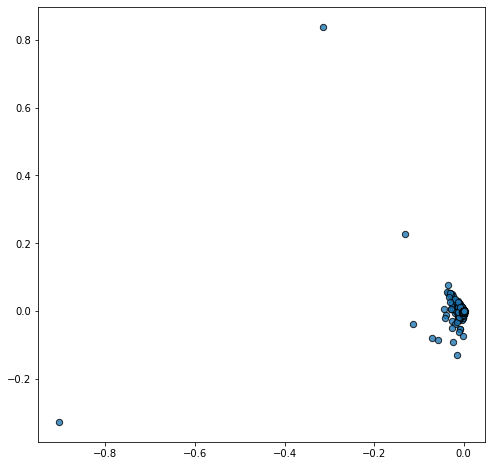

In [23]:
X=transformer.components_.T[:,0]
y=transformer.components_.T[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            #c=c,
            marker="o",
            #cmap=cmap,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

In [24]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=2, random_state=0)
transformer.fit(matrix)

PCA(n_components=2, random_state=0)

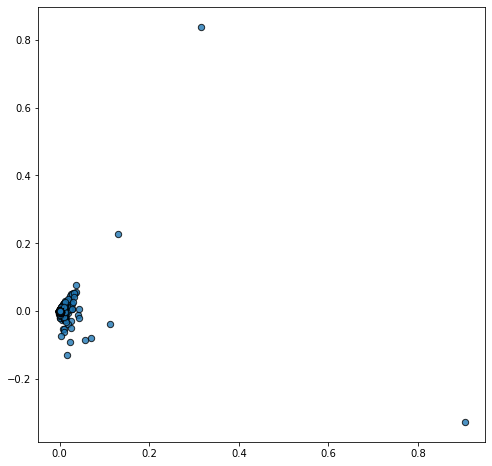

In [25]:
X=transformer.components_.T[:,0]
y=transformer.components_.T[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            #c=c,
            marker="o",
            #cmap=cmap,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

In [27]:
Y = pdist(matrix, 'euclidean')

In [28]:
Y.shape

(378015,)

In [29]:
mdist = squareform(Y, force='no', checks=True)

In [30]:
mdist.shape

(870, 870)

In [31]:
mdist

array([[    0.        , 63884.38081409, 58721.96869145, ...,
        33937.65542874, 28578.5884361 , 30398.39249039],
       [63884.38081409,     0.        , 42612.61997343, ...,
        78083.04215385, 66958.41874626, 55638.22362369],
       [58721.96869145, 42612.61997343,     0.        , ...,
        64793.9376871 , 58502.01618748, 55016.62398766],
       ...,
       [33937.65542874, 78083.04215385, 64793.9376871 , ...,
            0.        , 16836.67933412, 32883.00202232],
       [28578.5884361 , 66958.41874626, 58502.01618748, ...,
        16836.67933412,     0.        , 22116.03520073],
       [30398.39249039, 55638.22362369, 55016.62398766, ...,
        32883.00202232, 22116.03520073,     0.        ]])

In [32]:
from scipy.spatial.distance import is_valid_dm

In [33]:
is_valid_dm(mdist)

True

In [36]:
import seaborn as sns#; sns.set_theme()


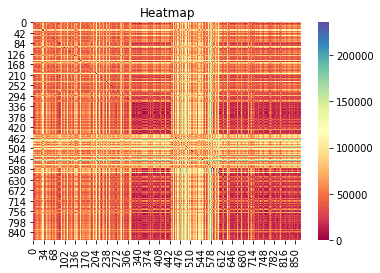

In [37]:
#Heatmap

ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

plt.title('Heatmap')
plt.savefig('heatmap',dpi=100)

In [129]:
from sklearn.decomposition import KernelPCA


In [130]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)
kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=42)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]

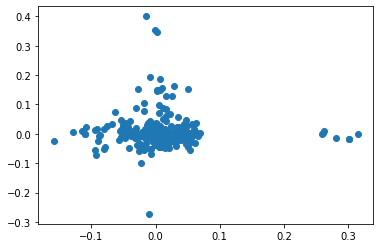

In [131]:
plt.scatter(X,y)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Unlabeled UMAP Embedding in 2D')

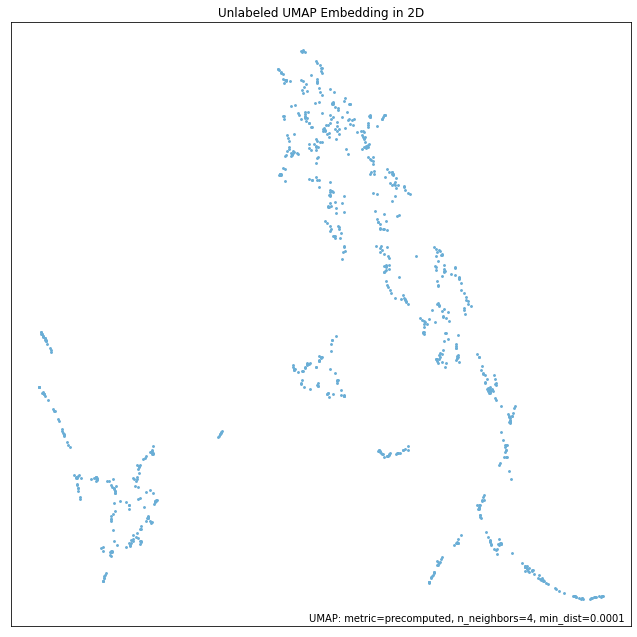

In [93]:
#Create 2-d umap dimensionality reduction embedding to visualize unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4)
umap_embedding = umap_model_2d.fit_transform(mdist)
plot.points(umap_model_2d)

plt.title('Unlabeled UMAP Embedding in 2D')

In [94]:
umap_embedding.shape

(870, 2)

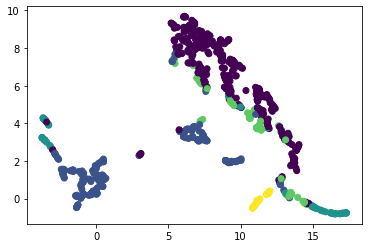

In [95]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],c=y)

In [108]:
umap_model_33d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=33)
umap_embedding_33d = umap_model_33d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


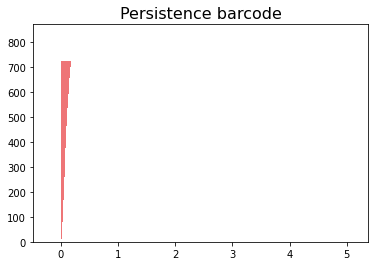

In [109]:
rips_complex = gudhi.RipsComplex(points=umap_embedding_33d)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
diag = simplex_tree.persistence()

gudhi.plot_persistence_barcode(diag)
plt.show()

In [110]:
persistence_module = simplex_tree.persistence()

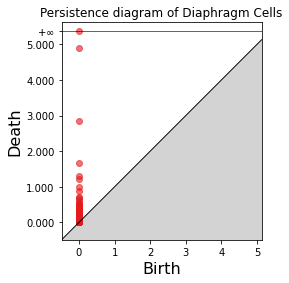

In [111]:
ax = gudhi.plot_persistence_diagram(persistence=persistence_module)
# We can modify the title, aspect, etc.
ax.set_title("Persistence diagram of Diaphragm Cells")
ax.set_aspect("equal")  # forces to be square shaped
plt.show()

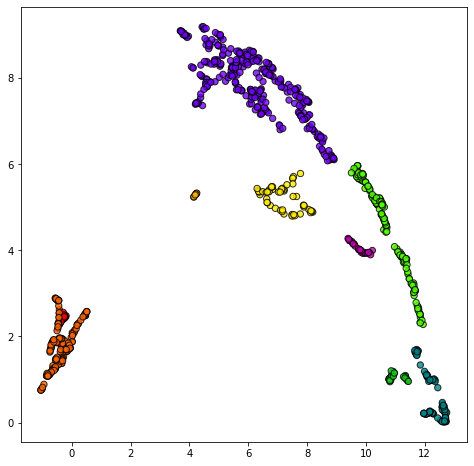

In [114]:

pogo.fit(umap_embedding_33d)
pogo.plot()

In [115]:
pogo.idx_

10014

In [116]:
pogo.labels_

array([0, 1, 1, 2, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 0,
       3, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 4, 1, 2, 0, 2, 2, 2, 2, 2, 4, 5, 1, 1, 1, 0, 1, 1,
       6, 7, 3, 8, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0,
       3, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 3, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 3,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 3, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 5, 1, 2, 7, 3, 8, 3, 2,
       2, 2, 1, 1, 2, 2, 3, 3, 2, 2, 0, 2, 0, 2, 0, 0, 8, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 4, 2, 1, 1, 0, 2, 0, 4, 2, 0, 2, 2, 4, 1, 1, 1, 0, 0,
       1, 1, 2, 2, 3, 8, 2, 2, 2, 1, 1, 0, 0, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 6,
       8, 1, 2, 0, 7, 2, 1, 1, 1, 2, 7, 0, 2, 2, 2,

In [117]:
pogo.candidates_

[37094,
 75242,
 25627,
 16693,
 10875,
 14342,
 22945,
 7195,
 5428,
 9017,
 4762,
 8230,
 10014,
 6692,
 6439,
 4466,
 7043,
 3995,
 3743,
 4278,
 3645,
 3908,
 4698,
 3535,
 4404,
 4149,
 3505,
 3843,
 6387,
 4200,
 3603,
 3722,
 3891,
 4382,
 4242,
 3626,
 3490,
 4677,
 4368,
 4261,
 4273,
 4757,
 3601,
 46076,
 46085,
 46290,
 46083,
 46289,
 46288,
 46084,
 46353,
 46304,
 46086,
 46423,
 46082,
 46087,
 46422,
 46421,
 46088,
 46426,
 46287,
 46305,
 46286,
 46291,
 46292,
 46352,
 46077,
 46425,
 46075,
 46351,
 46078,
 46301,
 46300,
 46299,
 46079,
 46298,
 46297,
 46074,
 46296,
 46080,
 46295,
 46302,
 46294,
 46081,
 46303,
 46293,
 46424,
 46089,
 46285,
 46306,
 46105,
 46106,
 46107,
 46418,
 46108,
 46357,
 46417,
 46109,
 46110,
 46111,
 46416,
 46278,
 46277,
 46112,
 46113,
 46276,
 46275,
 46274,
 46114,
 46273,
 46272,
 46115,
 46116,
 46279,
 46104,
 46103,
 46095,
 46090,
 46284,
 46091,
 46092,
 46420,
 46354,
 46093,
 46283,
 46094,
 46282,
 46281,
 46102,
 46

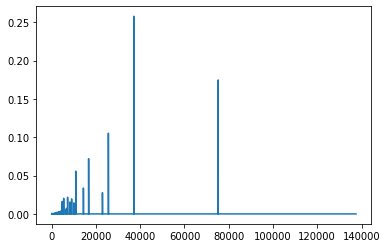

In [118]:
plt.plot(pogo.gap_vector_)

Maximum Silhouette: 10014


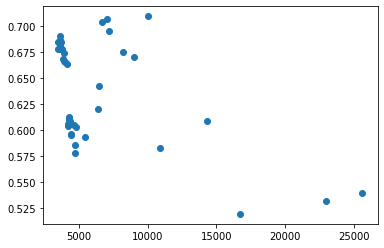

In [119]:
silhouette_indices, silhouette_array = pogo.plot_silhouette()

Maximum Silhouette Score: 25627


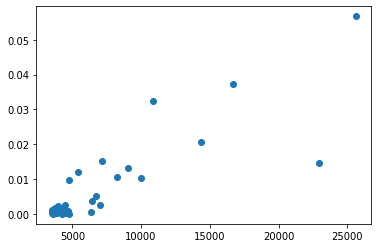

In [120]:
score_indices, score_array = pogo.plot_silhouette_score()

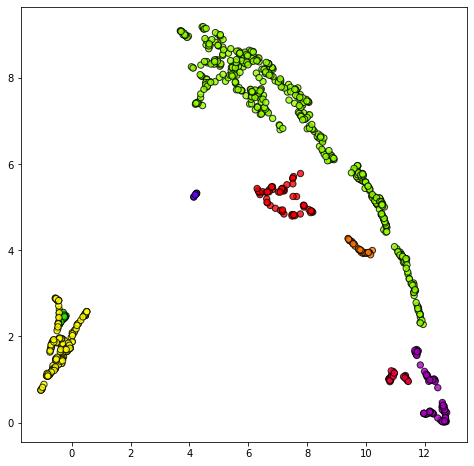

In [121]:
pogo.plot(13636)

Maximum Rand Score: 10875


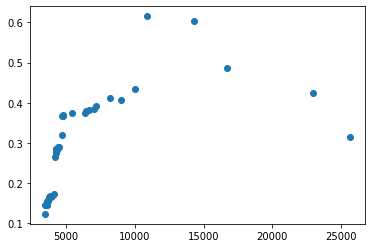

In [122]:
rand_indices, rand_array = pogo.plot_rand_score(y)


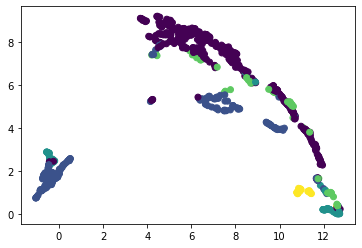

In [138]:
plt.scatter(umap_embedding_33d[:,0],umap_embedding_33d[:,1],c=ground_truth)